In [1]:
import numpy as np
import matplotlib.pyplot as plt
from traj_opt import TrajOpt
from scipy.optimize import minimize, Bounds, NonlinearConstraint

import matplotlib.animation as animation
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

In [2]:
ndof = 2
num_via = 6

## 2 DoF - Reaching task with 1 via point, optimization of the duration

In [3]:
l1 = 1.
l2 = 0.5

def fk_x(q):
    return np.array([l1 * np.cos(q[0]) + l2 * np.cos(q[0]+q[1])])
    
def fk_y(q):
    return l1 * np.sin(q[0]) + l2 * np.sin(q[0]+q[1])

def J_x(q):
    return np.array([[- l1 * np.sin(q[0]) - l2 * np.sin(q[0]+q[1]),- l2 * np.sin(q[0]+q[1])]])
    
def J_y(q):
    return np.array([[l1 * np.cos(q[0]) + l2 * np.cos(q[0]+q[1]),l2 * np.cos(q[0]+q[1])]])

def get_fk(x):
    fk_list = []
    for i in range(num_via):
        q = x[num_via+i*ndof:num_via+(i+1)*ndof]
        fk_list.append(np.array([fk_x(q), fk_y(q)]))
    return fk_list

In [4]:
def obstacle_cost(x):
    h = x[:num_via]
    q_via = x[num_via:]
    t_obs_array = np.linspace(0, np.sum(h), 100)
    to.setup_task(h)
    q_list = to.get_y(t_obs_array, np.concatenate((q_0, q_via)), dq_0, dq_T)
    d_min = np.inf
    for q in q_list:
        d = y_line - fk_y(q)
        if d < d_min:
            d_min = d
    return d_min

def target_var(x):
    fk_list = get_fk(x)
    return fk_list[-1][0]

In [5]:
def getIK_x(q0, g, alpha=0.1, numIter=100):
    q = q0
    for i in range(numIter):
        q_ = q - (alpha * np.linalg.pinv(J_x(q)) * (fk_x(q) - g)).reshape(2)
        q = q_
    return q_
    
def getIK_y(q0, g, alpha=0.1, numIter=100):
    q = q0
    for i in range(numIter):
        q_ = q - (alpha * np.linalg.pinv(J_y(q)) * (fk_y(q) - g)).reshape(2)
        q = q_
    return q_

In [6]:
def get_dq_max(x):
    h = x[:num_via]
    q_via = x[num_via:]
    to.setup_task(h)
    t_max = np.zeros(num_via*ndof)
    w = np.concatenate((q_0, q_via, dq_0, dq_T))
    for n in range(num_via):
        Omega = to.get_Omega(n)
        for d in range(ndof):
            w_d = w[d::ndof]
            alpha = Omega @ w_d
            t_max[n*ndof+d] = np.clip(np.sum(h[:n]) + alpha[1] / alpha[0], np.sum(h[:n]), np.sum(h[:n+1]))
    
    return to.get_dy(t_max, np.concatenate((q_0, q_via)), dq_0, dq_T).flatten()

In [7]:
def get_ddq_max(x):
    h = x[:num_via]
    q_via = x[num_via:]
    to.setup_task(h)
    t_nodes = np.zeros(num_via+1)
    for n in range(num_via):
        t_nodes[n+1] = np.sum(h[:n+1])
    
    return to.get_ddy(t_nodes, np.concatenate((q_0, q_via)), dq_0, dq_T).flatten()

In [8]:
x_line = 1.2
y_line = 1.0

N_samples = 100

q_samples_1 = np.zeros((N_samples, 2))
q_samples_2 = np.zeros((N_samples, 2))

for n in range(N_samples):
    q_init = np.array([np.random.uniform(0.0,np.pi), np.random.uniform(-np.pi,np.pi)])
    q_samples_1[n] = getIK_x(q_init, x_line)
    q_samples_2[n] = getIK_y(q_init, y_line)

In [9]:
q_0 = np.array([2.0, 1.5])
# q_0 = np.array([np.random.uniform(0.8,np.pi-0.8), np.random.uniform(-np.pi+0.8,np.pi-0.8)])
# while y_line - fk_y(q_0) < 1e-3:
#     q_0 = np.array([np.random.uniform(0.8,np.pi-0.8), np.random.uniform(-np.pi+0.8,np.pi-0.8)])

dq_0 = np.array([0., 0.])
dq_T = np.array([0., 0.])

x_init = 0.1 * np.ones((ndof+1)*num_via)

for i in range(num_via):
    x_init[num_via+i*ndof:num_via+(i+1)*ndof] = np.array([np.random.uniform(0.8,np.pi-0.8), np.random.uniform(-np.pi+0.8,np.pi-0.8)])

dq_lim = 0.8
ddq_lim = 2

to = TrajOpt(ndof)
    
fun = lambda x: np.sum(x[:num_via])
lower_bounds_x = 0.1 * np.ones((ndof+1)*num_via)
upper_bounds_x = 10.0 * np.ones((ndof+1)*num_via)
for i in range(num_via):
    lower_bounds_x[num_via+i*ndof:num_via+(i+1)*ndof] = np.array([0, -np.pi])
    upper_bounds_x[num_via+i*ndof:num_via+(i+1)*ndof] = np.array([np.pi, np.pi])

bound = Bounds(lower_bounds_x, upper_bounds_x, keep_feasible=True)
nlc_obstacle = NonlinearConstraint(obstacle_cost, 1e-3, np.inf)
nlc_fk_2 = NonlinearConstraint(target_var, x_line-1e-3, x_line+1e-3)
nlc_dq = NonlinearConstraint(get_dq_max, -dq_lim, dq_lim)
nlc_ddq = NonlinearConstraint(get_ddq_max, -ddq_lim, ddq_lim)

import time
start = time.time()

res = minimize(fun, x_init, method='SLSQP', bounds=bound, constraints=[nlc_obstacle, nlc_fk_2, nlc_dq, nlc_ddq])

print("Elapsed time: ",time.time()-start," [s]")

print(res.x, get_dq_max(res.x), get_ddq_max(res.x))
T_opt = res.x[:num_via]
q_via = res.x[num_via:]

<ipython-input-3-cc7c13a6a705>:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  fk_list.append(np.array([fk_x(q), fk_y(q)]))


Elapsed time:  15.75414490699768  [s]
[0.7999995  0.10260273 0.21357466 1.29099965 0.10000177 0.34999916
 1.57333373 1.86516128 1.49125154 1.91804628 1.32039179 1.96932226
 0.28759257 1.25814432 0.2109246  1.18407127 0.08842519 1.06450194] [-8.00000000e-01  5.69356146e-01 -7.59935718e-01  6.20970879e-01
 -8.00000105e-01  4.37172595e-01 -8.00000000e-01  5.69356146e-01
 -8.00000132e-01  3.09646638e-01 -8.00000000e-01  5.94831620e-02
 -7.99999422e-01 -6.46291175e-01 -7.99999732e-01 -8.00000000e-01
 -8.00000000e-01 -7.79559534e-01 -8.00000000e-01 -7.79559555e-01
 -2.20488647e-15 -1.17213639e-14 -6.99998316e-01 -6.74883276e-01] [-2.00000000e+00  2.00000000e+00 -1.25240238e-06 -5.76608744e-01
 -8.03079331e-07 -2.00000000e+00  1.79039509e-06 -1.53683747e+00
 -1.79039939e-06  2.37003321e-01  2.00000000e+00  1.85648514e+00
  2.00000000e+00  2.00000000e+00]


In [10]:
h = T_opt
T = np.sum(h)
t = np.linspace(0,T,int(1000*T))

q_nodes = np.concatenate((q_0, q_via), axis=0)

to.setup_task(h)

q = to.get_y(t, q_nodes, dq_0, dq_T)
dq = to.get_dy(t, q_nodes, dq_0, dq_T)
ddq = to.get_ddy(t, q_nodes, dq_0, dq_T)

q_nodes = q_nodes.reshape((num_via+1, ndof))

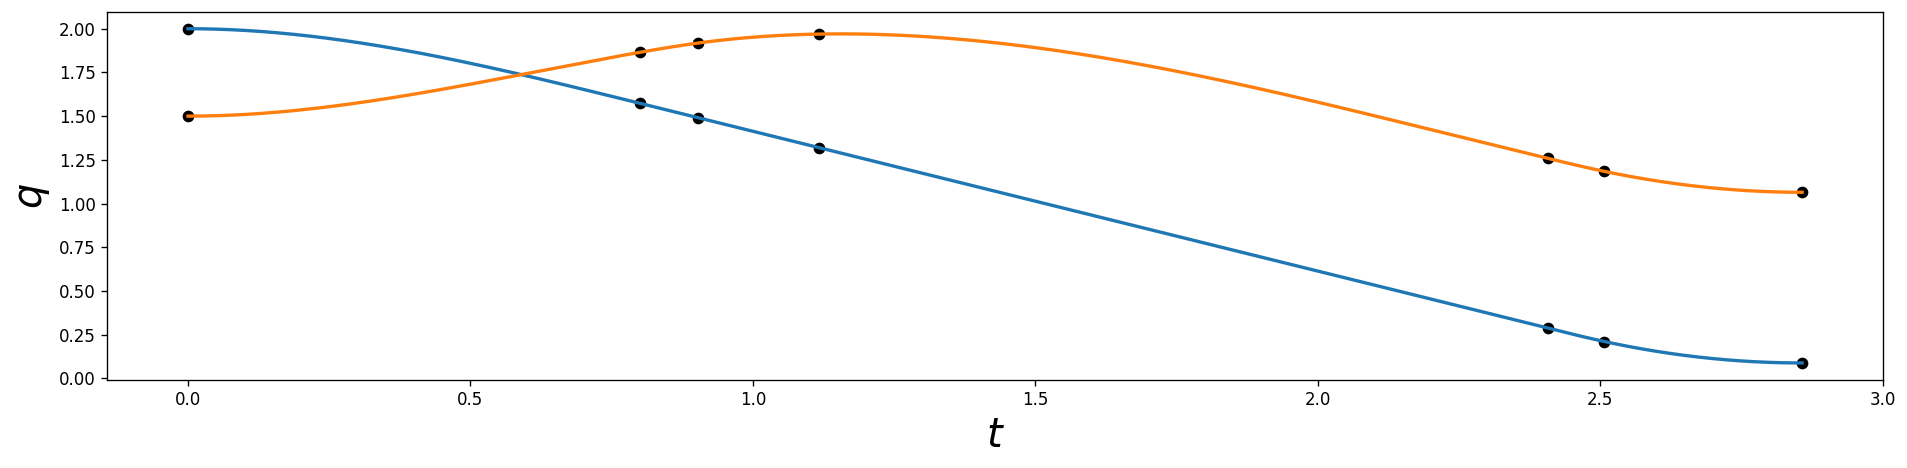

In [11]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$q$', fontsize=fontsize_)

plt.plot(t, q, lw=lw_)

for n in range(num_via+1):
    plt.scatter(np.sum(h[:n])*np.ones(ndof), q_nodes[n], color='k')
    
plt.tight_layout()
#plt.savefig("space_time_optimal_y.png")

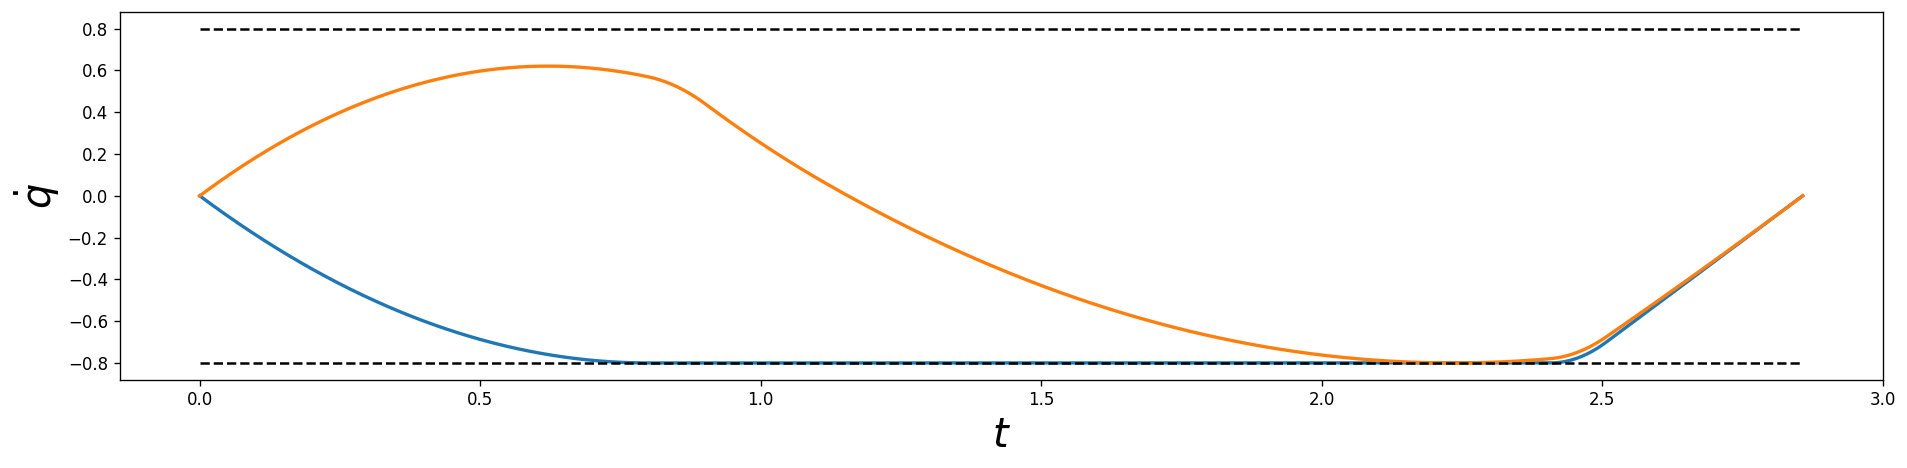

In [12]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\dot{q}$', fontsize=fontsize_)

plt.plot(t, dq, lw=lw_)

plt.plot([0,T], [dq_lim, dq_lim], 'k--')
plt.plot([0,T], [-dq_lim, -dq_lim], 'k--')

plt.tight_layout()
#plt.savefig("space_time_optimal_dq.png")

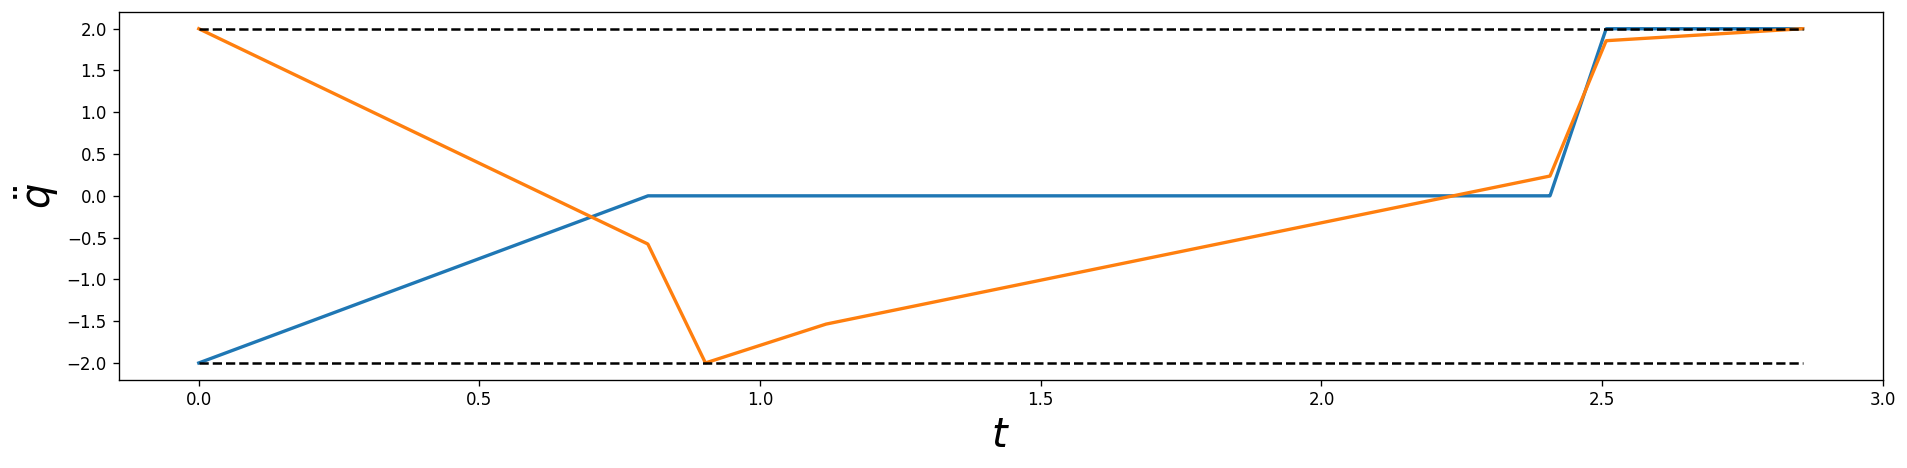

In [13]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\ddot{q}$', fontsize=fontsize_)

plt.plot(t, ddq, lw=lw_)

plt.plot([0,T], [ddq_lim, ddq_lim], 'k--')
plt.plot([0,T], [-ddq_lim, -ddq_lim], 'k--')

plt.tight_layout()
#plt.savefig("space_time_optimal_ddq.png")

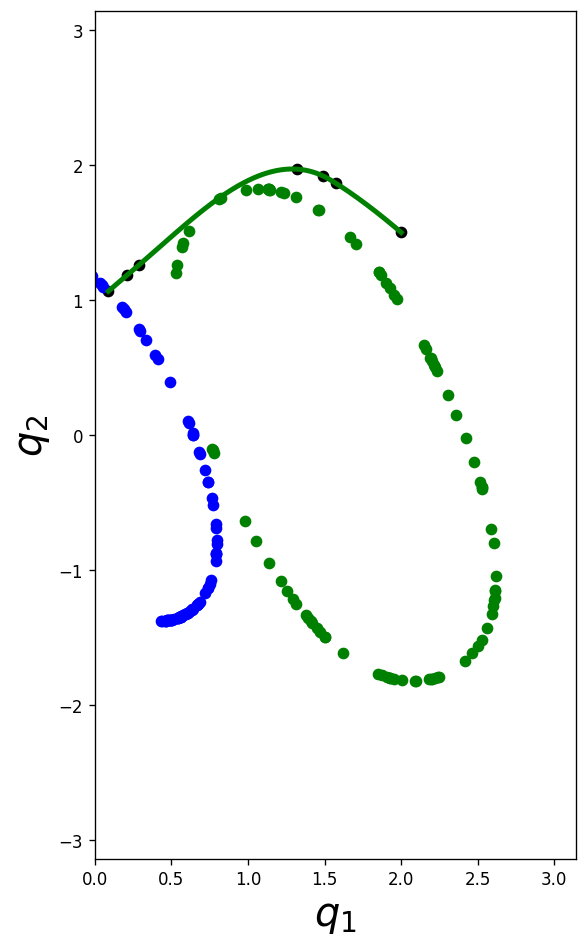

In [14]:
plt.figure(figsize=(5, 8), dpi= 120, facecolor='w', edgecolor='k')

plt.plot(q[:,0], q[:,1], 'g', lw=3)

plt.scatter(q_nodes[:,0], q_nodes[:,1], c='k')

plt.scatter(q_samples_1[:,0], q_samples_1[:,1], color='b')
plt.scatter(q_samples_2[:,0], q_samples_2[:,1], color='g')

plt.xlim(0,np.pi)
plt.ylim(-np.pi,np.pi)

plt.xlabel(r'$q_1$', fontsize = 24)
plt.ylabel(r'$q_2$', fontsize = 24)

plt.tight_layout()
#plt.savefig("space_time_optimal_q.png")

## Visualize the Robot from an array of configurations

In [15]:
Q = q

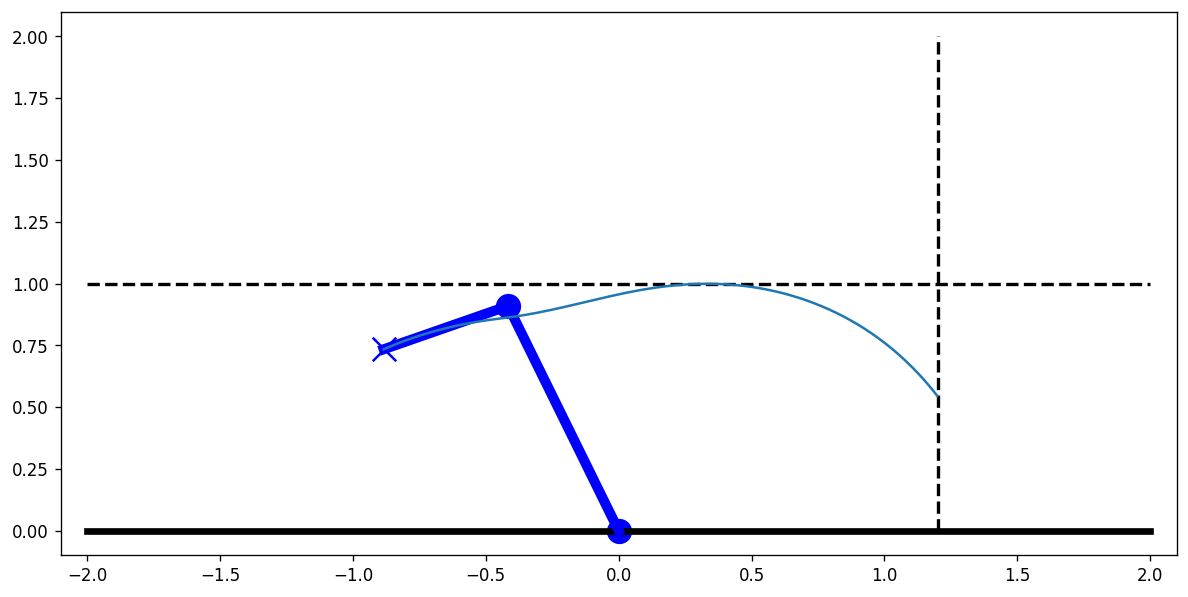

In [16]:
fig, ax = plt.subplots(figsize=(12, 6), dpi= 120, facecolor='w', edgecolor='k')

N_ = len(Q)

dt = T / N_
dt_ani = 0.04

# forward kinematics
Xs = np.zeros((N_,3,2))

for n in range(N_):
    q_ = Q[n]
    Xs[n,1,0] = l1 * np.cos(q_[0])
    Xs[n,1,1] = l1 * np.sin(q_[0])
    Xs[n,2,0] = l1 * np.cos(q_[0]) + l2 * np.cos(q_[0]+q_[1])
    Xs[n,2,1] = l1 * np.sin(q_[0]) + l2 * np.sin(q_[0]+q_[1])
    
# table line
ax.plot([-2., 2.], [0., 0.], lw=4, color='k')

ax.plot([-2., 2.], [y_line, y_line], 'k--', lw=2)
ax.plot([x_line, x_line], [0, 2], 'k--', lw=2)

# draw robot links, joints and end effector
link_plot, = ax.plot(Xs[0,:,0], Xs[0,:,1], lw=6, color='b')
joint_plot = ax.scatter(Xs[0,:-1,0], Xs[0,:-1,1], s=200, color='b')
ee_plot = ax.scatter(Xs[0,-1,0], Xs[0,-1,1], s=200, marker='x', color='b')

ax.plot(Xs[:,-1,0], Xs[:,-1,1])

axes = plt.gca()
axes.set_xlim([-2.1,2.1])
axes.set_ylim([-0.1,2.1])

def animate(i_):
    i = int(i_*dt_ani/dt)
    link_plot.set_xdata(Xs[i,:,0])
    link_plot.set_ydata(Xs[i,:,1])
    joint_plot.set_offsets(Xs[i,:-1,:])
    ee_plot.set_offsets(Xs[i,-1,:])
    return link_plot, joint_plot, ee_plot

#ani = animation.FuncAnimation(
#    fig, animate, interval=dt_ani*1e3, blit=True, frames=int(T/dt_ani), repeat=False)

#HTML(ani.to_html5_video())